In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from features import lat_lng2dist_ang
from cmdstanpy import CmdStanModel, set_cmdstan_path
import contextily as ctx
import os
import arviz as az

sns.set_theme()

GEOLOCATION = "nm"
TRANSFORMED_CSV = f"datasets/processed/{GEOLOCATION}/transformed.csv"
GT_POINTS_CSV = f"datasets/raw/{GEOLOCATION}/gt_points.csv"
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = "bivariate_normal.stan"

set_cmdstan_path(CMDSTAN_PATH)


transformed_df = pd.read_csv(TRANSFORMED_CSV)
gt_points_df = pd.read_csv(GT_POINTS_CSV)
gt_points_df["plot_label"] = gt_points_df["name"]
transformed_df["plot_label"] = transformed_df["measured_from"] + " measurements"

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gt_points_df

,name,lat,lng,plot_label
0,P1,45.828472,15.220485,P1
1,P2,45.828432,15.220255,P2
2,P3,45.828386,15.220487,P3
3,E,45.828369,15.220408,E


In [3]:
transformed_df

,measured_from,lat,lng,distance,angle_rad,angle_deg,plot_label
0,P1,45.828472,15.220483,0.164687,4.958584,284.105911,P1 measurements
1,P1,45.828475,15.220475,0.879406,5.120334,293.373508,P1 measurements
2,P1,45.828475,15.220481,0.512605,5.460975,312.890843,P1 measurements
3,P1,45.828475,15.220475,0.879406,5.120334,293.373508,P1 measurements
4,P1,45.828481,15.220478,1.132972,5.734002,328.534122,P1 measurements
...,...,...,...,...,...,...,...
126,P3,45.828408,15.220336,12.009810,4.923723,282.108560,P3 measurements
127,P3,45.828403,15.220347,11.044222,4.885445,279.915379,P3 measurements
128,P3,45.828403,15.220358,10.194841,4.900028,280.750909,P3 measurements
129,P3,45.828367,15.220608,9.643805,1.791580,102.649954,P3 measurements


/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


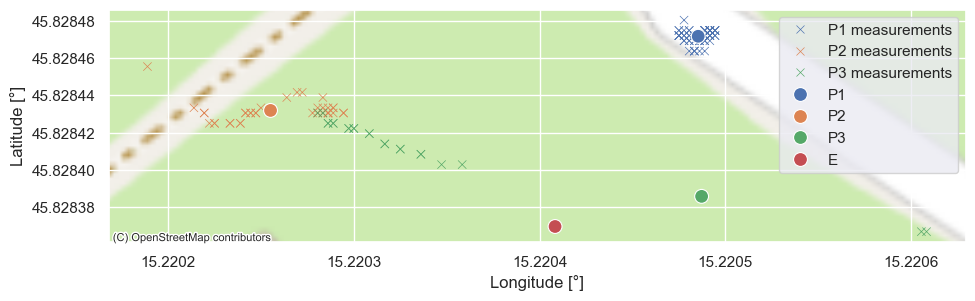

In [4]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.scatterplot(
    data=transformed_df, x="lng", y="lat", hue="plot_label", ax=ax, marker="x"
)
sns.scatterplot(data=gt_points_df, x="lng", y="lat", hue="plot_label", ax=ax, s=100)
ctx.add_basemap(ax, crs="epsg:4326", source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
# disable scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.legend(title="")
# ax.legend().set_visible(False)
# Save the plot
plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_geomap.png")

In [5]:
P1_lat, P1_lng = (
    gt_points_df[gt_points_df["name"] == "P1"][["lat", "lng"]].values[0].tolist()
)
P2_lat, P2_lng = (
    gt_points_df[gt_points_df["name"] == "P2"][["lat", "lng"]].values[0].tolist()
)
P3_lat, P3_lng = (
    gt_points_df[gt_points_df["name"] == "P3"][["lat", "lng"]].values[0].tolist()
)
E_lat, E_lng = (
    gt_points_df[gt_points_df["name"] == "E"][["lat", "lng"]].values[0].tolist()
)
E_P1_dist, E_P1_angle_rad, E_P1_angle_deg = lat_lng2dist_ang(
    [P1_lat, P1_lng], [E_lat, E_lng]
)
E_P2_dist, E_P2_angle_rad, E_P2_angle_deg = lat_lng2dist_ang(
    [P2_lat, P2_lng], [E_lat, E_lng]
)
E_P3_dist, E_P3_angle_rad, E_P3_angle_deg = lat_lng2dist_ang(
    [P3_lat, P3_lng], [E_lat, E_lng]
)

print(f"P1: {P1_lat}, {P1_lng}")
print(f"P2: {P2_lat}, {P2_lng}")
print(f"P3: {P3_lat}, {P3_lng}")
print(f"E: {E_lat}, {E_lng}")
print(
    f"E using P1 as the center: dist={E_P1_dist}, angle_rad={E_P1_angle_rad}, angle_deg={E_P1_angle_deg}"
)
print(
    f"E using P2 as the center: dist={E_P2_dist}, angle_rad={E_P2_angle_rad}, angle_deg={E_P2_angle_deg}"
)
print(
    f"E using P3 as the center: dist={E_P3_dist}, angle_rad={E_P3_angle_rad}, angle_deg={E_P3_angle_deg}"
)


P1: 45.82847186111111, 15.22048538888889
P2: 45.82843192982457, 15.220255146198827
P3: 45.82838566784871, 15.220487234042553
E: 45.82836944444445, 15.220408333333332
E using P1 as the center: dist=12.86199270467897, angle_rad=3.625805158152281, angle_deg=207.7433328988897
E using P2 as the center: dist=13.78101524512164, angle_rad=2.0989763923570286, angle_deg=120.26248857965328
E using P3 as the center: dist=6.390458846451682, angle_rad=4.426333776256516, angle_deg=253.61024409570237


In [6]:
# choose pair of proposals to compare and remove the rest
COMPARE_PROPOSALS = ["P2", "P3"]
gt_points_df = gt_points_df[gt_points_df["name"].isin(COMPARE_PROPOSALS + ["E"])].copy().reset_index(drop=True)
transformed_df = transformed_df[transformed_df["measured_from"].isin(COMPARE_PROPOSALS)].copy().reset_index(drop=True)

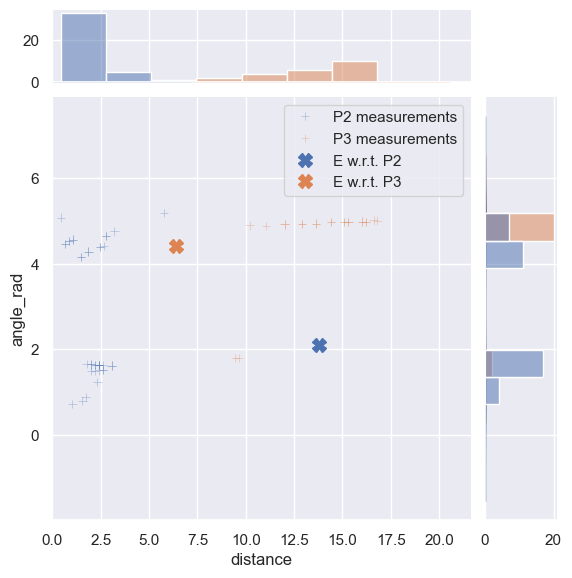

In [7]:
#! P1(measured) and P2(measured) are measurements that are transformed to dist and angle WITH RESPECT TO THEIR GROUND TRUTH (P1 or P2)
g = sns.jointplot(
    data=transformed_df,
    x="distance",
    y="angle_rad",
    hue="plot_label",
    kind="scatter",
    marginal_ticks=True,
    joint_kws={"marker": "+"},
    alpha=0.4
)

# lower bound for distance is 0
g.ax_joint.set_xlim(left=0)
g.plot_marginals(sns.histplot)

proposals = gt_points_df["name"].values.tolist()
proposals.remove("E")

for proposal_name in proposals:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][
        ["lat", "lng"]
    ].values[0]
    dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    g.ax_joint.plot(
        dist, angle_rad, "X", label=f"E w.r.t. {proposal_name}", markersize=10
    )
g.ax_joint.legend()

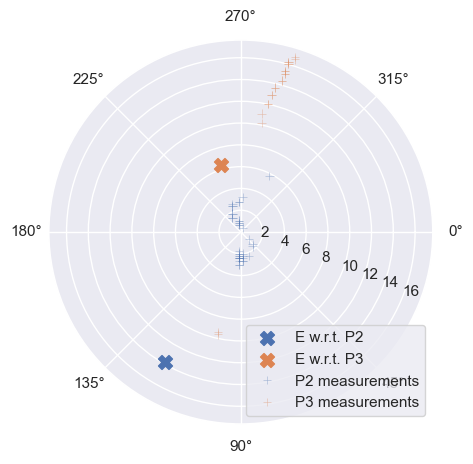

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

for proposal_name in proposals:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][
        ["lat", "lng"]
    ].values[0]
    dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    ax.scatter(angle_rad, dist, marker="X", label=f"E w.r.t. {proposal_name}", s=100)


sns.scatterplot(
    data=transformed_df,
    x="angle_rad",
    y="distance",
    hue="plot_label",
    ax=ax,
    marker="+",
    alpha=0.4,
)
# ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
# ax.set_rlabel_position(0)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.legend(title="", loc="lower right")
plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_polar.pdf")

In [9]:
# P1 vs P2
# stan_data = {
#     "N1": transformed_df[transformed_df["measured_from"] == "P1"].shape[0],
#     "N2": transformed_df[transformed_df["measured_from"] == "P2"].shape[0],
#     "y1": transformed_df[transformed_df["measured_from"] == "P1"][
#         ["distance", "angle_rad"]
#     ].values.tolist(),
#     "y2": transformed_df[transformed_df["measured_from"] == "P2"][
#         ["distance", "angle_rad"]
#     ].values.tolist(),
#     "E_p1": [E_P1_dist, E_P1_angle_rad],
#     "E_p2": [E_P2_dist, E_P2_angle_rad],
# }

#P1 vs P3
# stan_data = {
#     "N1": transformed_df[transformed_df["measured_from"] == "P1"].shape[0],
#     "N2": transformed_df[transformed_df["measured_from"] == "P3"].shape[0],
#     "y1": transformed_df[transformed_df["measured_from"] == "P1"][
#         ["distance", "angle_rad"]
#     ].values.tolist(),
#     "y2": transformed_df[transformed_df["measured_from"] == "P3"][
#         ["distance", "angle_rad"]
#     ].values.tolist(),
#     "E_p1": [E_P1_dist, E_P1_angle_rad],
#     "E_p3": [E_P3_dist, E_P3_angle_rad],
# }

# P2 and P3
stan_data = {
    "N1": transformed_df[transformed_df["measured_from"] == "P2"].shape[0],
    "N2": transformed_df[transformed_df["measured_from"] == "P3"].shape[0],
    "y1": transformed_df[transformed_df["measured_from"] == "P2"][
        ["distance", "angle_rad"]
    ].values.tolist(),
    "y2": transformed_df[transformed_df["measured_from"] == "P3"][
        ["distance", "angle_rad"]
    ].values.tolist(),
    "E_p1": [E_P2_dist, E_P2_angle_rad],
    "E_p2": [E_P3_dist, E_P3_angle_rad],
}
    
# Sanity check to make sure we have selected the measurements corresponding to the correct proposals
# if this fails, than it means that we are comparing e.g. P1 vs P2, but giving the data for P1 vs P3
assert stan_data["N1"] > 0
assert stan_data["N2"] > 0
assert stan_data["N1"] + stan_data["N2"] == transformed_df.shape[0] # transformed_df at this point contains only the measurements for the two proposals we are comparing

model = CmdStanModel(stan_file=STAN_MODEL_PATH)
fit = model.sample(
    data=stan_data,
    chains=4,
    iter_warmup=1000,
    iter_sampling=4000,
    seed=1,
    parallel_chains=os.cpu_count(),
)

display(fit.summary())
print(fit.diagnose())

18:52:54 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
18:52:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:00 Iteration:  700 / 5000 [ 14%]  (Warmup)





chain 1 |███▍      | 00:00 Iteration: 1500 / 5000 [ 30%]  (Sampling)
chain 1 |████▊     | 00:00 Iteration: 2200 / 5000 [ 44%]  (Sampling)


chain 1 |██████▏   | 00:00 Iteration: 2900 / 5000 [ 58%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 3500 / 5000 [ 70%]  (Sampling)


chain 1 |████████▍ | 00:00 Iteration: 4100 / 5000 [ 82%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 4700 / 5000 [ 94%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


18:52:55 - cmdstanpy - INFO - CmdStan done processing.
18:52:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-90.97000,0.028383,2.367210,-95.38720,-90.61270,-87.77540,6955.81,2129.76,1.000920
mu1[1],2.08301,0.001092,0.164111,1.81561,2.08358,2.35187,22578.70,6913.27,0.999968
mu1[2],2.88211,0.001856,0.267127,2.43928,2.88218,3.32133,20710.20,6341.14,0.999844
mu2[1],13.86150,0.004536,0.527570,12.99990,13.86090,14.72000,13524.80,4141.10,1.000040
mu2[2],4.67317,0.001768,0.214547,4.31636,4.67470,5.02356,14726.40,4509.00,0.999930
...,...,...,...,...,...,...,...,...,...
"y2_rep[20,2]",4.67613,0.008028,1.020380,3.01582,4.67336,6.33743,16155.00,4946.43,1.000190
"y2_rep[21,1]",13.87350,0.020106,2.522250,9.74187,13.87710,18.05730,15737.00,4818.43,0.999905
"y2_rep[21,2]",4.66063,0.008070,1.021920,2.99429,4.65828,6.34666,16034.90,4909.64,0.999786
"y2_rep[22,1]",13.83780,0.020826,2.518720,9.74864,13.82840,17.90370,14626.50,4478.41,0.999914


Processing csv files: /tmp/tmpvbjdjqpg/bivariate_normallsf0z311/bivariate_normal-20240831185254_1.csv, /tmp/tmpvbjdjqpg/bivariate_normallsf0z311/bivariate_normal-20240831185254_2.csv, /tmp/tmpvbjdjqpg/bivariate_normallsf0z311/bivariate_normal-20240831185254_3.csv, /tmp/tmpvbjdjqpg/bivariate_normallsf0z311/bivariate_normal-20240831185254_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'mu2\n0'}>,
        <Axes: title={'center': 'mu2\n0'}>],
       [<Axes: title={'center': 'mu2\n1'}>,
        <Axes: title={'center': 'mu2\n1'}>]], dtype=object)

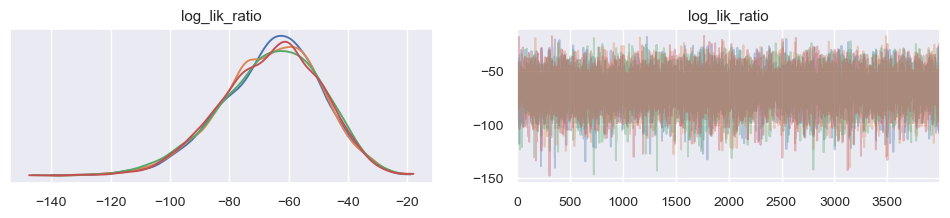

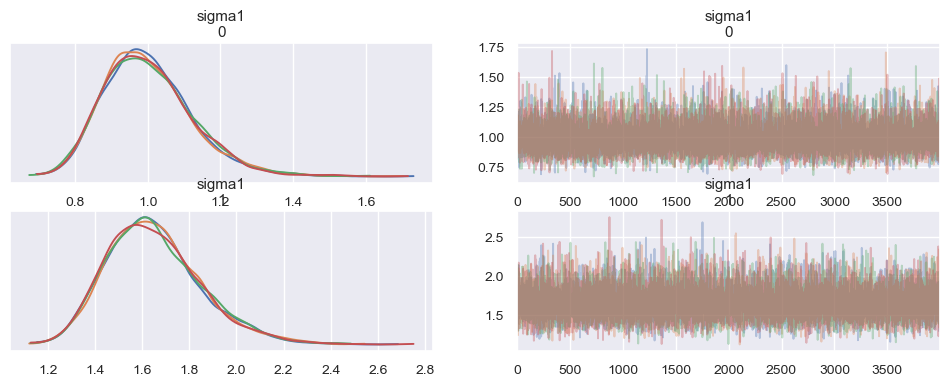

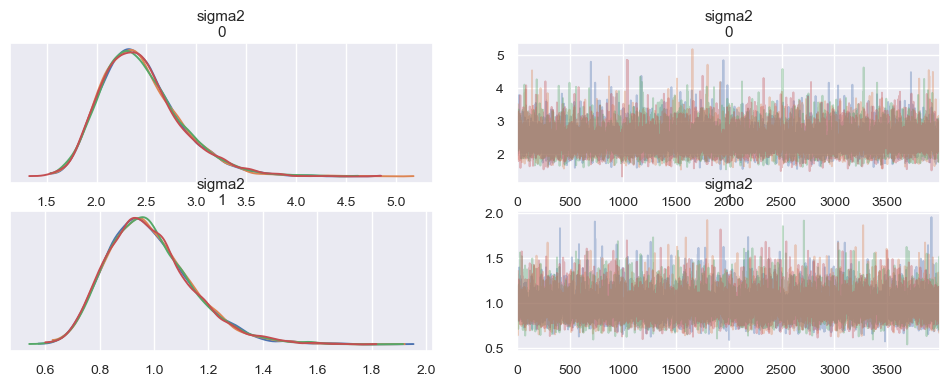

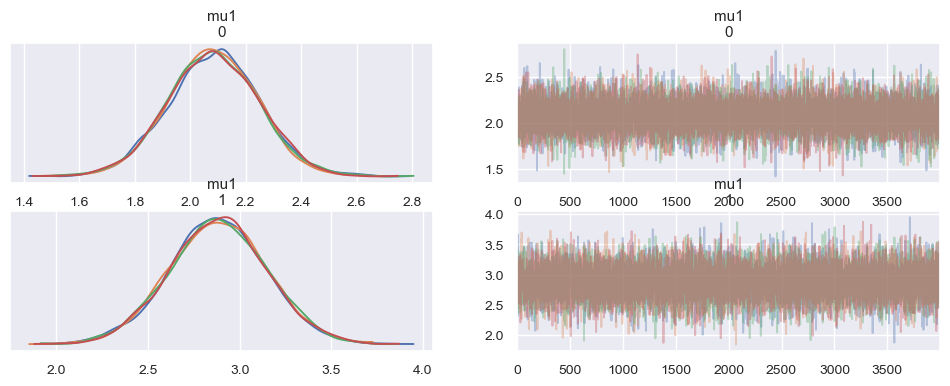

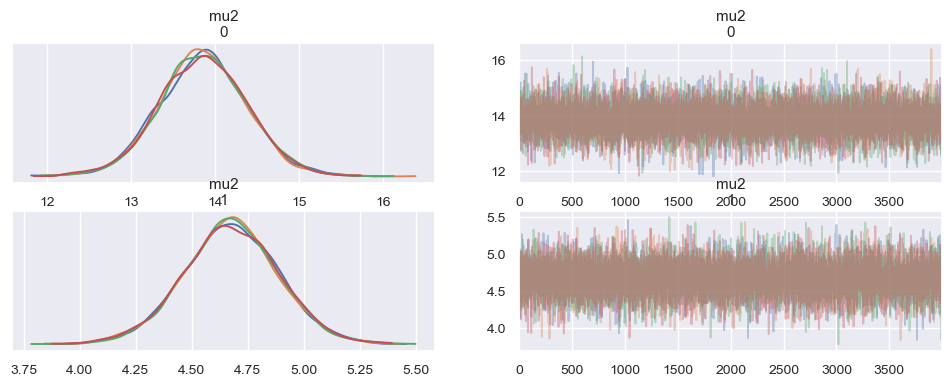

In [10]:
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="log_lik_ratio")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^sigma1")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^sigma2")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^mu1")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^mu2")

(16000, 39, 2)
(16000, 22, 2)
(5, 39, 2)
(5, 22, 2)


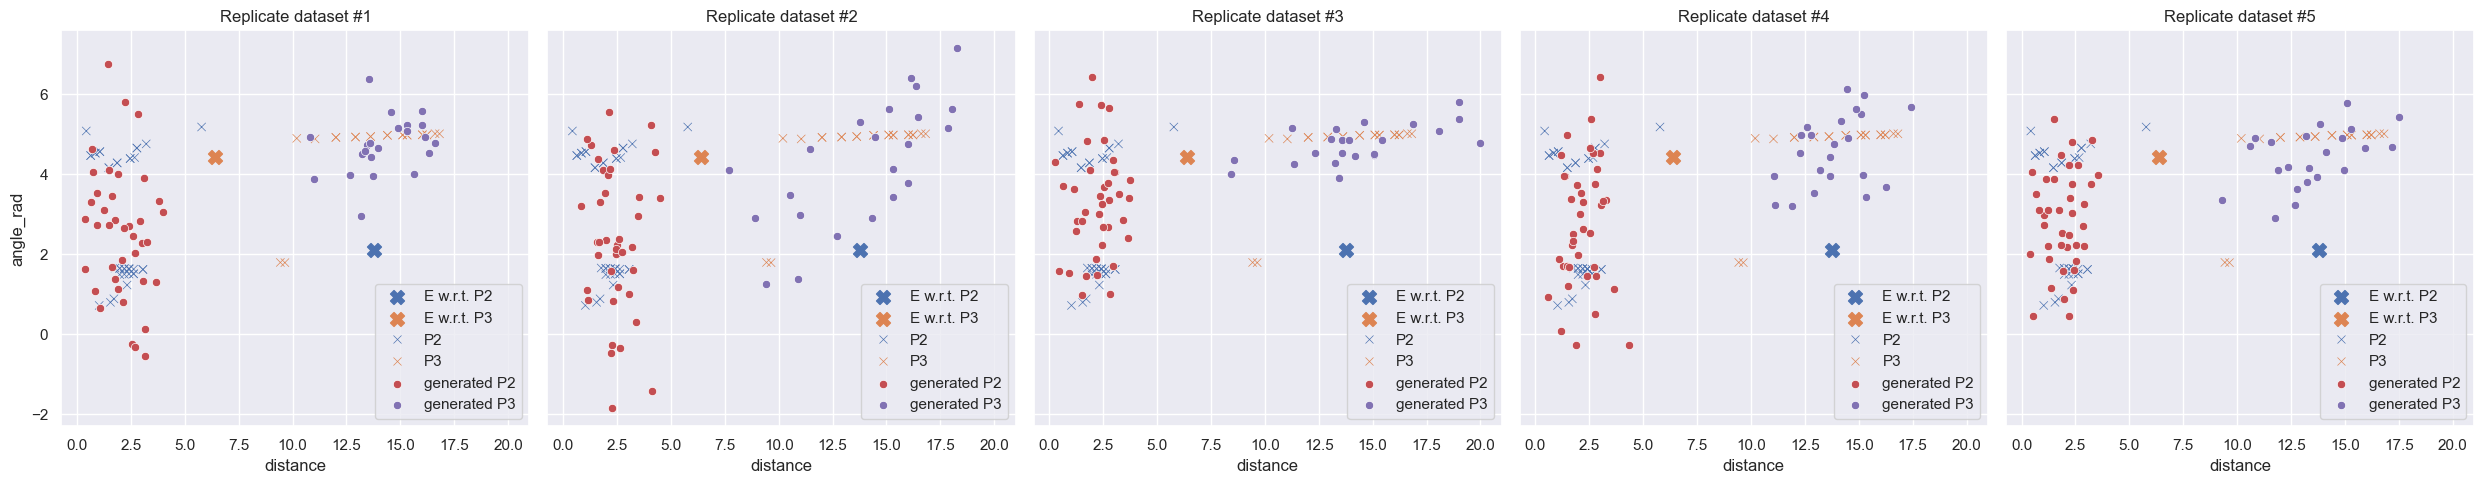

In [11]:

replicate_datasets_p1 = fit.y1_rep
print(replicate_datasets_p1.shape) # n_draws x n_measurements_p1 x 2 (distance, angle_rad)
replicate_datasets_p2 = fit.y2_rep
print(replicate_datasets_p2.shape) # n_draws x n_measurements_p2 x 2 (distance, angle_rad)

# randomly select 5 replicate datasets for each proposal
n_replicates = 5
replicate_indices = np.random.choice(
    replicate_datasets_p1.shape[0], n_replicates, replace=False
)
replicate_datasets_p1 = replicate_datasets_p1[replicate_indices]
replicate_datasets_p2 = replicate_datasets_p2[replicate_indices]
print(replicate_datasets_p1.shape)
print(replicate_datasets_p2.shape)

# plot the posterior predictive
fig, ax = plt.subplots(
    1, n_replicates, figsize=(n_replicates * 5, 5), sharex=True, sharey=True
)
for i in range(n_replicates):
    for proposal_name in proposals:
        proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][
            ["lat", "lng"]
        ].values[0]
        dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
        ax[i].scatter(dist, angle_rad, marker="X", label=f"E w.r.t. {proposal_name}", s=100)
    # ax[i].scatter(E_P1_dist, E_P1_angle_rad, label="E w.r.t. P1", marker="X", s=100)
    # ax[i].scatter(E_P2_dist, E_P2_angle_rad, label="E w.r.t. P2", marker="X", s=100)
    sns.scatterplot(
        data=transformed_df,
        x="distance",
        y="angle_rad",
        hue="measured_from",
        ax=ax[i],
        marker="x",
    )
    sns.scatterplot(
        data=pd.DataFrame(replicate_datasets_p1[i], columns=["distance", "angle_rad"]),
        x="distance",
        y="angle_rad",
        ax=ax[i],
        label=f"generated {COMPARE_PROPOSALS[0]}",
    )
    sns.scatterplot(
        data=pd.DataFrame(replicate_datasets_p2[i], columns=["distance", "angle_rad"]),
        x="distance",
        y="angle_rad",
        ax=ax[i],
        label=f"generated {COMPARE_PROPOSALS[1]}",
    )
    
    ax[i].set_title(f"Replicate dataset #{i + 1}")
    ax[i].set_xlabel("distance")
    ax[i].set_ylabel("angle_rad")
    ax[i].legend()

plt.tight_layout()


Mean log likelihood ratio: -66.1000164125 +- 0.11204314593356376, 95% HDI: [-100.444   -34.2875]


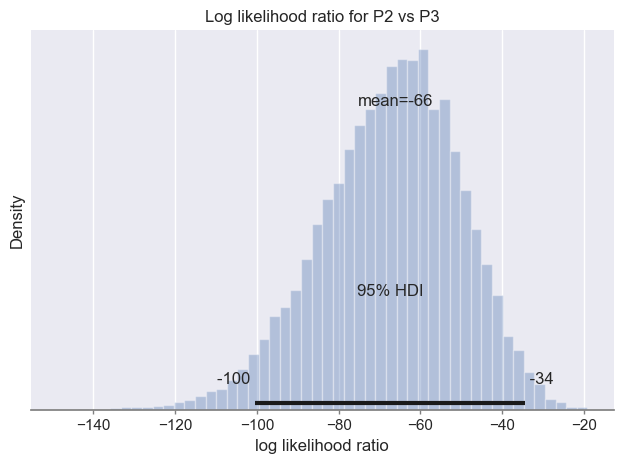

In [12]:
ax = az.plot_posterior(fit, var_names=["log_lik_ratio"], kind="hist", hdi_prob=0.95, bins=50)
ax.set_xlabel("log likelihood ratio")
ax.set_ylabel("Density")
ax.axis("on")
ax.set_title(f"log likelihood ratio for {COMPARE_PROPOSALS[0]} vs {COMPARE_PROPOSALS[1]}")

plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_{COMPARE_PROPOSALS[0]}_vs_{COMPARE_PROPOSALS[1]}_log_lik_ratio.pdf")

log_lik_ratio = fit.log_lik_ratio
mean_lr = np.mean(log_lik_ratio)
mcse_lr = az.stats.mcse(log_lik_ratio)

print(
    f"Mean log likelihood ratio: {mean_lr} +- {mcse_lr}, 95% HDI: {az.hdi(log_lik_ratio, hdi_prob=0.95)}"
)